In [1]:
#from pioran import PSDToACV
#from pioran.psd import OneBendPowerLaw


from NSmodels import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle
import matplotlib.transforms as transforms
import re
#import corner
from scipy.stats import gaussian_kde

from tinygp import kernels
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from prettytable import PrettyTable

#from stingray.simulator import simulator
#import random
import jaxns
from scipy.signal import savgol_filter

#from jaxns import ExactNestedSampler
#from jaxns import TerminationCondition

import tensorflow_probability.substrates.jax.distributions as tfpd

from tinygp import GaussianProcess
from THESIS import LightCurveSampler, JAXNSmodelCreator, ModelComparison

from functools import partial
import pickle
import types
from functools import partial
import warnings
warnings.filterwarnings('ignore')


INFO[2025-03-22 11:22:12,717]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2025-03-22 11:22:12,717]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2025-03-22 11:22:12,731]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO[2025-03-22 11:22:16,684]: arviz_base not installed
INFO[2025-03-22 11:22:16,685]: arviz_stats not installed
INFO[2025-03-22 11:22:16,686]: arviz_plots not installed


In [2]:
simDATA = pd.read_csv('simDATAcsvs/simDATA_highALPHA_3_NumofWINDOW_12_period_0.75_6_A1_0.015_0.3.csv')
row = simDATA[545:546]
row

ID  simSEED  sampleSEED   rms  noiseSIGMA  bendfreq  lowalpha  \
545  1545.0  38291.0      5686.0  0.15       0.015   0.00137      -1.0   

     highalpha  sharpness  period   A1  NightsperWINDOW  OBSperiod  \
545       -3.0       10.0    0.75  0.3               20          3   

     WINDOWwidth  dataLOSSfrac  NumofWINDOW  
545           35           0.2           12

In [3]:
simDATA

ID  simSEED  sampleSEED   rms  noiseSIGMA  bendfreq  lowalpha  \
0     1000.0  10177.0     54953.0  0.15       0.015   0.00137      -1.0   
1     1001.0  10177.0     54953.0  0.15       0.015   0.00137      -1.0   
2     1002.0  10177.0     54953.0  0.15       0.015   0.00137      -1.0   
3     1003.0  10177.0     54953.0  0.15       0.015   0.00137      -1.0   
4     1004.0  10177.0     54953.0  0.15       0.015   0.00137      -1.0   
...      ...      ...         ...   ...         ...       ...       ...   
2395  3395.0  98150.0     74756.0  0.15       0.015   0.00137      -1.0   
2396  3396.0  98150.0     74756.0  0.15       0.015   0.00137      -1.0   
2397  3397.0  98150.0     74756.0  0.15       0.015   0.00137      -1.0   
2398  3398.0  98150.0     74756.0  0.15       0.015   0.00137      -1.0   
2399  3399.0  98150.0     74756.0  0.15       0.015   0.00137      -1.0   

      highalpha  sharpness  period     A1  NightsperWINDOW  OBSperiod  \
0          -3.0       10.0   0.375  0.015               20          3   
1          -3.0       10.0   0.375  0.072               20          3   
2          -3.0       10.0   0.375  0.129               20          3   
3          -3.0       10.0   0.375  0.186               20          3   
4          -3.0       10.0   0.375  0.243               20          3   
...         ...        ...     ...    ...              ...        ...   
2395       -3.0       10.0   3.000  0.072               20          3   
2396       -3.0       10.0   3.000  0.129               20          3   
2397       -3.0       10.0   3.000  0.186               20          3   
2398       -3.0       10.0   3.000  0.243               20          3   
2399       -3.0       10.0   3.000  0.300               20          3   

      WINDOWwidth  dataLOSSfrac  NumofWINDOW  
0              35           0.2           12  
1              35           0.2           12  
2              35           0.2           12  
3              35           0.2           12  
4              35           0.2           12  
...           ...           ...          ...  
2395           35           0.2           12  
2396           35           0.2           12  
2397           35           0.2           12  
2398           35           0.2           12  
2399           35           0.2           12  

[2400 rows x 16 columns]

In [4]:
def sin_curve(A, period, phase , time):
    return A * np.sin(2 * np.pi/ period * time + phase)


In [5]:
0.5/365*4

0.005479452054794521

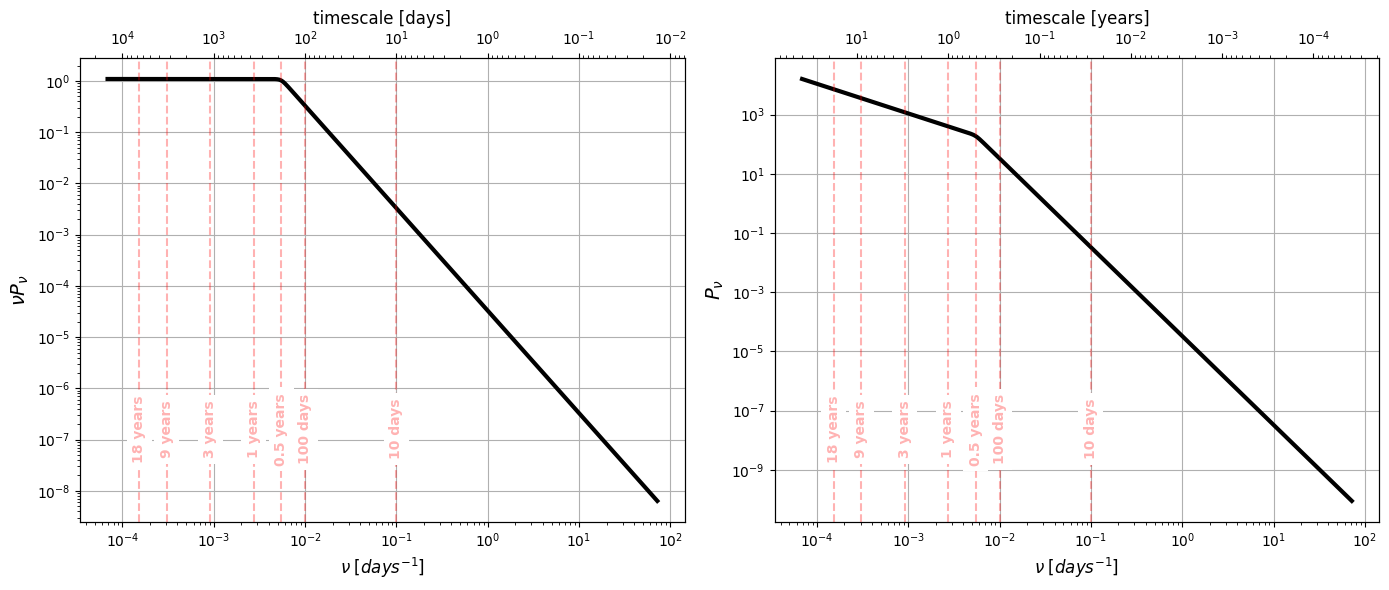

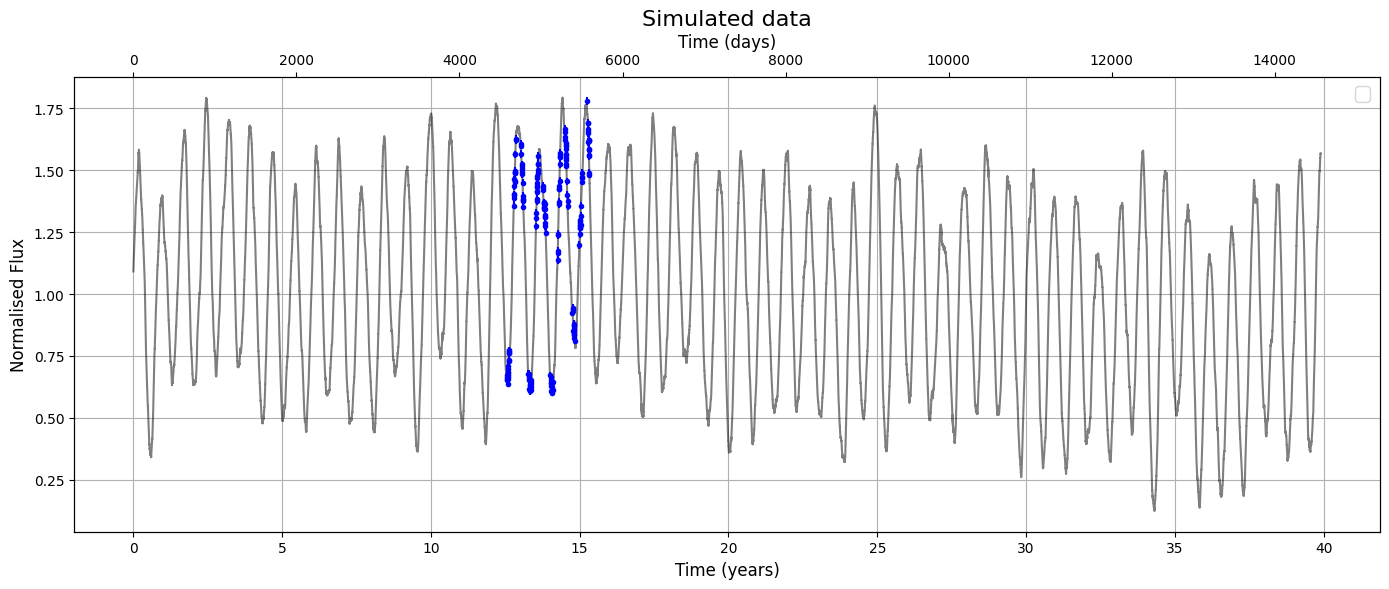

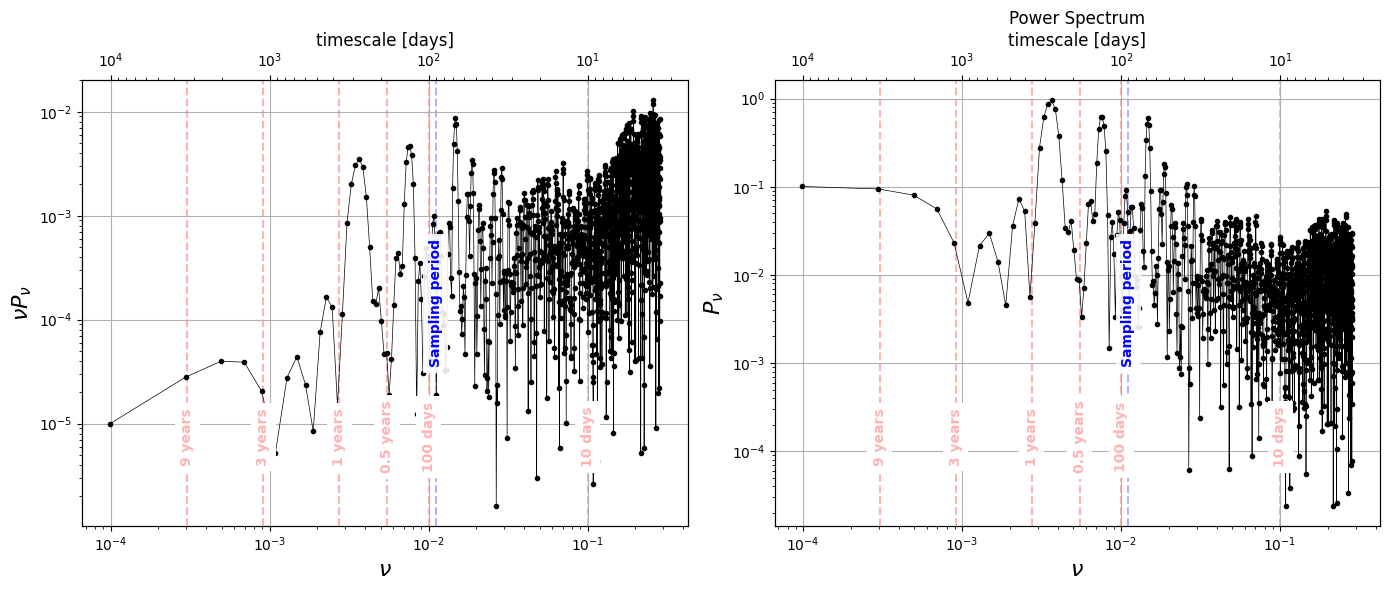

5.707762556994567e-05


In [6]:
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    '''
    Function for bend power_law creation
    '''
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

l = LightCurveSampler(N=2**21, rms=float(row.rms), simulatorSEED= int(row.simSEED), mean = partial(sin_curve, 0.5, row.period.to_numpy()[0], 0) , verbose=False)
l.load_powerspec(bend_pl, [200,  float(row.bendfreq)*4, 
                            float(row.lowalpha),
                            float(row.highalpha),
                            float(row.sharpness)], 
                            plot=True)
l.LCsimulator()
simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = int(row.NightsperWINDOW), 
                                            NumofWINDOW = int(row.NumofWINDOW),
                                            OBSperiod = float(row.OBSperiod),
                                            WINDOWwidth = float(row.WINDOWwidth),
                                            samplerSEED = int(row.sampleSEED),
                                            dataLOSSfrac = float(row.dataLOSSfrac), 
                                            noiseSIGMA = float(row.noiseSIGMA), plot=True)
print(np.min(np.diff(simTIME)))

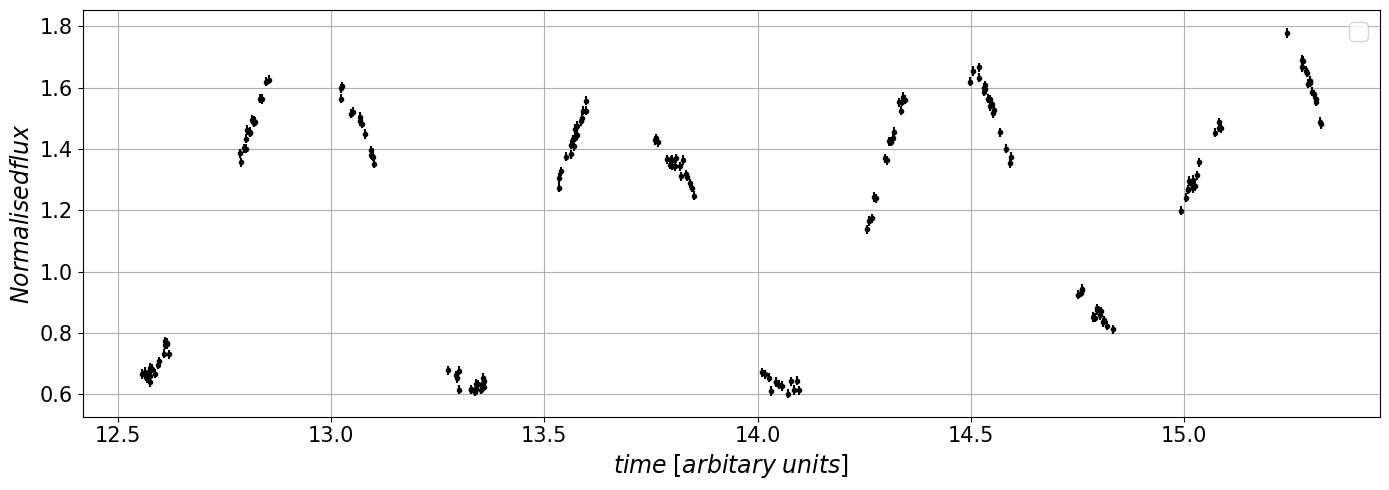

In [7]:
plt.figure(figsize=[14,5])
plt.errorbar(simTIME, simLC,yerr=simLCerr,fmt ='.', color='k')
#plt.plot(simTIME1, simLC1,'k.')
time_array = np.linspace(simTIME[0], simTIME[-2], 100)
#plt.plot(time_array, sin_curve(0.15*2, 1.4, 0, time_array ) + 1, color = 'lawngreen', lw=3, label = 'Periodic component' )
plt.grid()
plt.tick_params(labelsize=15)
plt.xlabel('$time\;[arbitary\;units]$', fontsize = 17)
plt.ylabel('$Normalised flux$', fontsize = 17)
plt.legend(fontsize=17)

plt.tight_layout()
#plt.savefig('plots/NAC/AGN_per_opaque.png', transparent = False)

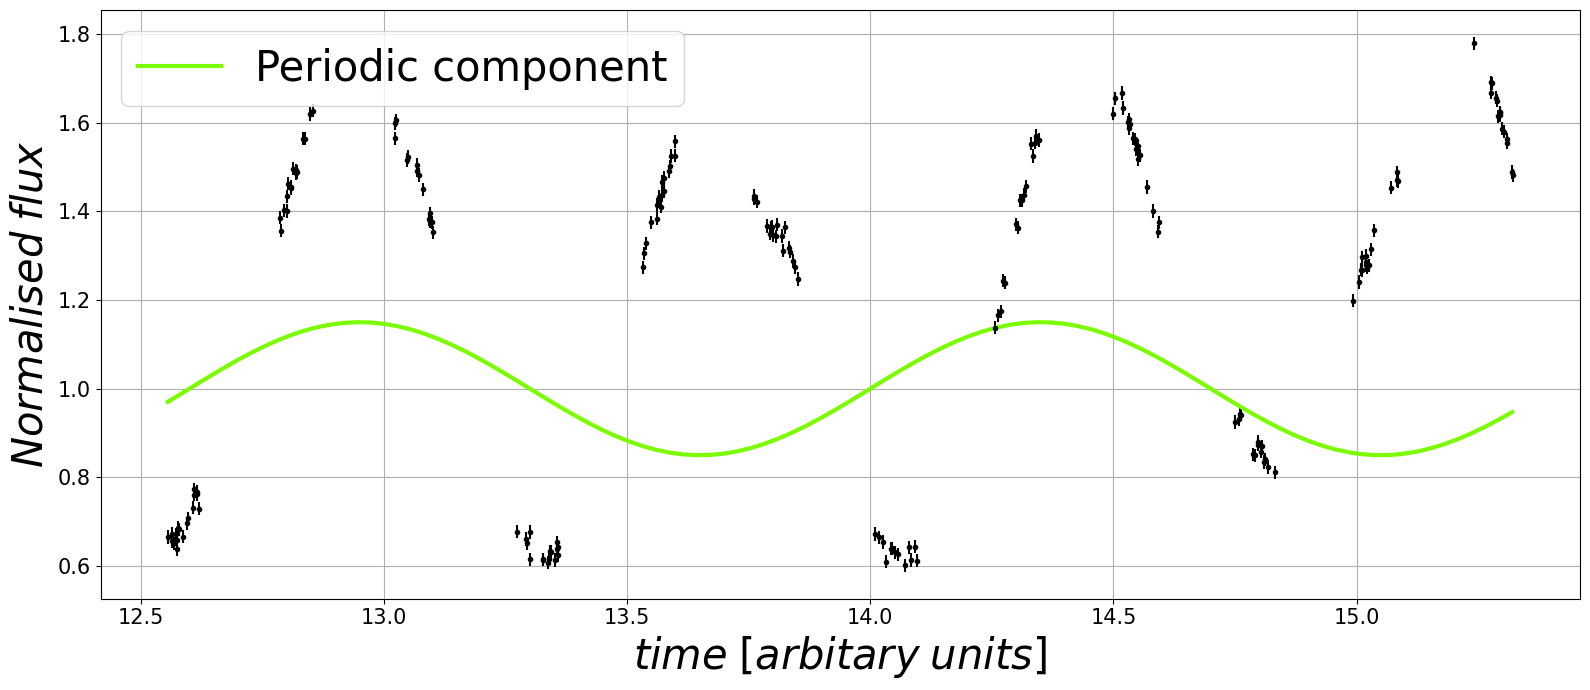

In [8]:
plt.figure(figsize=[16,7])
plt.errorbar(simTIME, simLC,yerr=simLCerr,fmt ='.', color='k')
#plt.plot(simTIME1, simLC1,'k.')
time_array = np.linspace(simTIME[0], simTIME[-2], 100)
plt.plot(time_array, sin_curve(0.15*1, 1.4, 0, time_array ) + 1, color = 'lawngreen', lw=3, label = 'Periodic component' )
plt.grid()
plt.tick_params(labelsize=15)
plt.xlabel('$time\;[arbitary\;units]$', fontsize = 30)
plt.ylabel('$Normalised\;flux$', fontsize = 30)
plt.legend(fontsize=30)

plt.tight_layout()
#plt.savefig('plots/NAC/AGN_per_transparent.png', transparent = True)

In [9]:
from NSmodels import *
import inspect

In [10]:
print(inspect.getsource(OBPL_generative_prior))

def OBPL_generative_prior(time  = None):
    alpha_l = yield jaxns.Prior( tfpd.Uniform(0, 2), name = 'alpha_l')
    alpha_h = yield jaxns.Prior( tfpd.Uniform(alpha_l , 4), name = 'alpha_h')
    log_bend_freq = yield jaxns.Prior( tfpd.Uniform(-5,2), name = 'log_bend_freq') # 1/years
    log_norm = yield jaxns.Prior( tfpd.Uniform(-3, 3), name = 'log_norm')
    #err_scale = yield jaxns.Prior(tfpd.Uniform(0.999,1.001), name='err_scale')
    
    return alpha_l, alpha_h, log_bend_freq, log_norm#, err_scale



In [11]:
lcTIME = simTIME
lcFLUX = simLC - np.median(simLC)
lcFLUXerr = simLCerr

modelCreater = JAXNSmodelCreator(lcTIME, lcFLUX, lcFLUXerr)

# DRW_NSmodel = modelCreater.create_model(DRW_generative_prior, DRW_log_likelihood_model)
# DRW_sine_NSmodel = modelCreater.create_model(DRW_sine_generative_prior, DRW_sine_log_likelihood_model)
OBPL_10_NSmodel = modelCreater.create_model(OBPL_generative_prior, OBPL_log_likelihood_model, n_component = 10)
# OBPL_4_NSmodel = modelCreater.create_model(OBPL_generative_prior, OBPL_log_likelihood_model, n_component = 4)
#OBPL_20_NSmodel = modelCreater.create_model(OBPL_generative_prior, OBPL_log_likelihood_model, n_component = 20)
# OBPLsine_10_NSmodel = modelCreater.create_model(OBPLsine_generative_prior, OBPLsine_log_likelihood_model, n_component = 10)
# CARMA21_sine_NSmodel = modelCreater.create_model(create_CARMAsine_JAXNS_model_funcs(2,1, functype='prior'),
#                                                     create_CARMAsine_JAXNS_model_funcs(2,1, functype='likelihood'))
# CARMA21_NSmodel = modelCreater.create_model(create_CARMA_JAXNS_model_funcs(2, 1, functype= 'prior'),
#                                                 create_CARMA_JAXNS_model_funcs(2,1, functype = 'likelihood'))
# # CARMA31_NSmodel = modelCreater.create_model(create_CARMA_JAXNS_model_funcs(3, 1, functype= 'prior'),
# #                                                 create_CARMA_JAXNS_model_funcs(3,1, functype = 'likelihood'))

ModelCOMP = ModelComparison(lcTIME, lcFLUX,lcFLUXerr, verbose=True)

# ModelCOMP.add_NestedModel(DRW_sine_NSmodel, 'DRWsine')
# ModelCOMP.add_NestedModel(DRW_NSmodel, 'DRW')

# #ModelCOMP.add_NestedModel(CARMA31_NSmodel, 'CARMA31')

# ModelCOMP.add_NestedModel(CARMA21_sine_NSmodel, 'CARMA21sine')
# ModelCOMP.add_NestedModel(CARMA21_NSmodel, 'CARMA21')
#ModelCOMP.add_NestedModel(OBPL_4_NSmodel, 'OBPL_4')
#ModelCOMP.add_NestedModel(OBPL_20_NSmodel, 'OBPL_20')
ModelCOMP.add_NestedModel(OBPL_10_NSmodel, 'OBPL_10')
# ModelCOMP.add_NestedModel(OBPLsine_10_NSmodel, 'OBPLsine_10')


Model Comparion object created.
JAXNS model added.


In [12]:
ModelCOMP.run_NSsampler()

Total number of models being sampled :  1
--------------------------------------------------------------------------
Model being sampled :  OBPL_10
-------------------------------------------------------------------------
DefaultNestedSampler Created. 
Sampling inititated.


TypeError: body_fun output and input must have identical types, got
Carry(key='ShapedArray(uint32[2])', direction='ShapedArray(float32[4])', left='DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', right='DIFFERENT ShapedArray(float64[]) vs. ShapedArray(float32[])', t='ShapedArray(float32[])', point_U='ShapedArray(float32[4])', log_L='ShapedArray(float32[])', num_likelihood_evaluations='ShapedArray(int32[])').

In [14]:
ModelCOMP.pretty_print()

+-----------------------+------------------------------+
|                       |           OBPL_10            |
+-----------------------+------------------------------+
|  Number of Parameters |              4               |
| Termination condition | ['Small remaining evidence'] |
|          logZ         |      416.2777539354097       |
|           H           |      -6.704577785474044      |
|          ESS          |      847.7685579231821       |
+-----------------------+------------------------------+


Model comparison results


In [15]:
# CARMA21_dict = ModelCOMP.return_samples_logZ_dict('CARMA21')
# CARMA21sine_dict = ModelCOMP.return_samples_logZ_dict('CARMA21sine')
# # CARMA31_dict = ModelCOMP.return_samples_logZ_dict('CARMA31')
# DRW_dict = ModelCOMP.return_samples_logZ_dict('DRW')
# DRWsine_dict = ModelCOMP.return_samples_logZ_dict('DRWsine')
OBPL10_dict = ModelCOMP.return_samples_logZ_dict('OBPL_10')
# OBPL_4_dict = ModelCOMP.return_samples_logZ_dict('OBPL_4')
#OBPLsine10_dict = ModelCOMP.return_samples_logZ_dict('OBPLsine_10')

In [18]:
import corner

In [19]:
def plot_corner(dictionary, exclude_keys=['log_Z_mean', 'log_Z_uncert']):
    if exclude_keys is None:
        exclude_keys = []

    filtered_data = {key: value for key, value in dictionary.items() if key not in exclude_keys}

    data = np.array([array for array in filtered_data.values()]).T
    
    fig = corner.corner(data, bins=50 ,  labels=list(filtered_data.keys()), show_titles=True, title_kwargs={"fontsize": 12})
    
    plt.show()

WARNING[2024-07-23 15:54:54,324]: Too few points to create valid contours


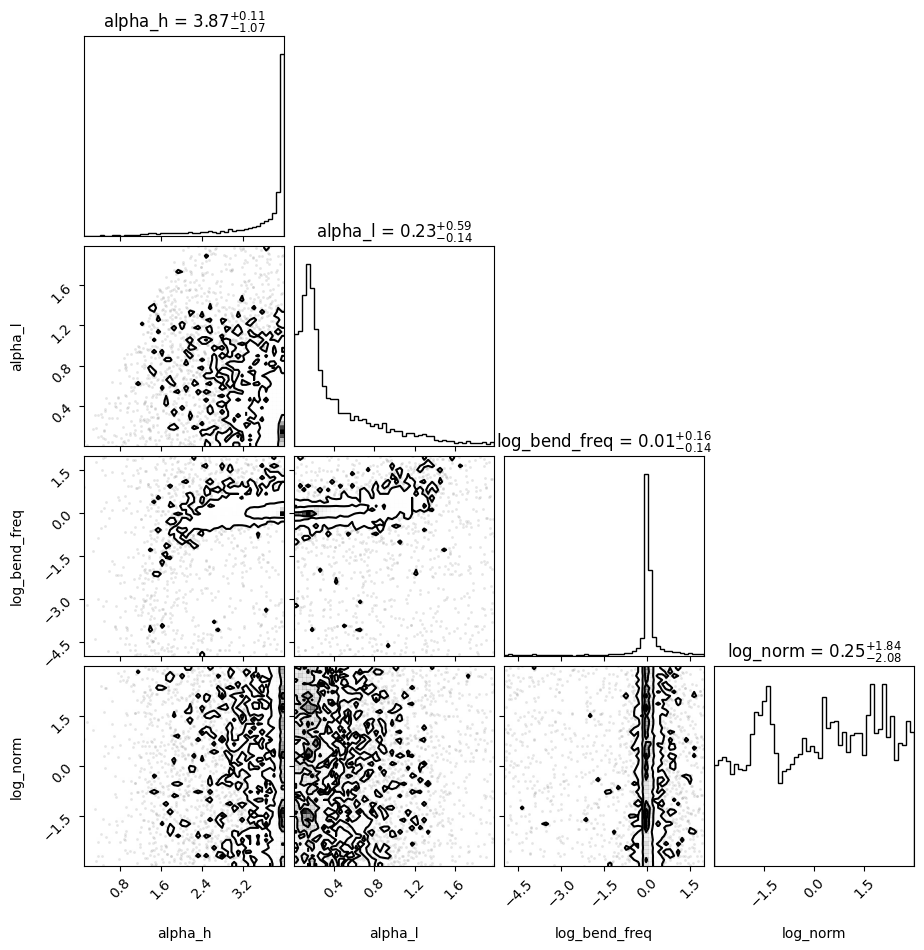

In [20]:
plot_corner(OBPL10_dict)

In [18]:
plot_corner(DRW_dict)
plot_corner(DRWsine_dict)

NameError: name 'corner' is not defined

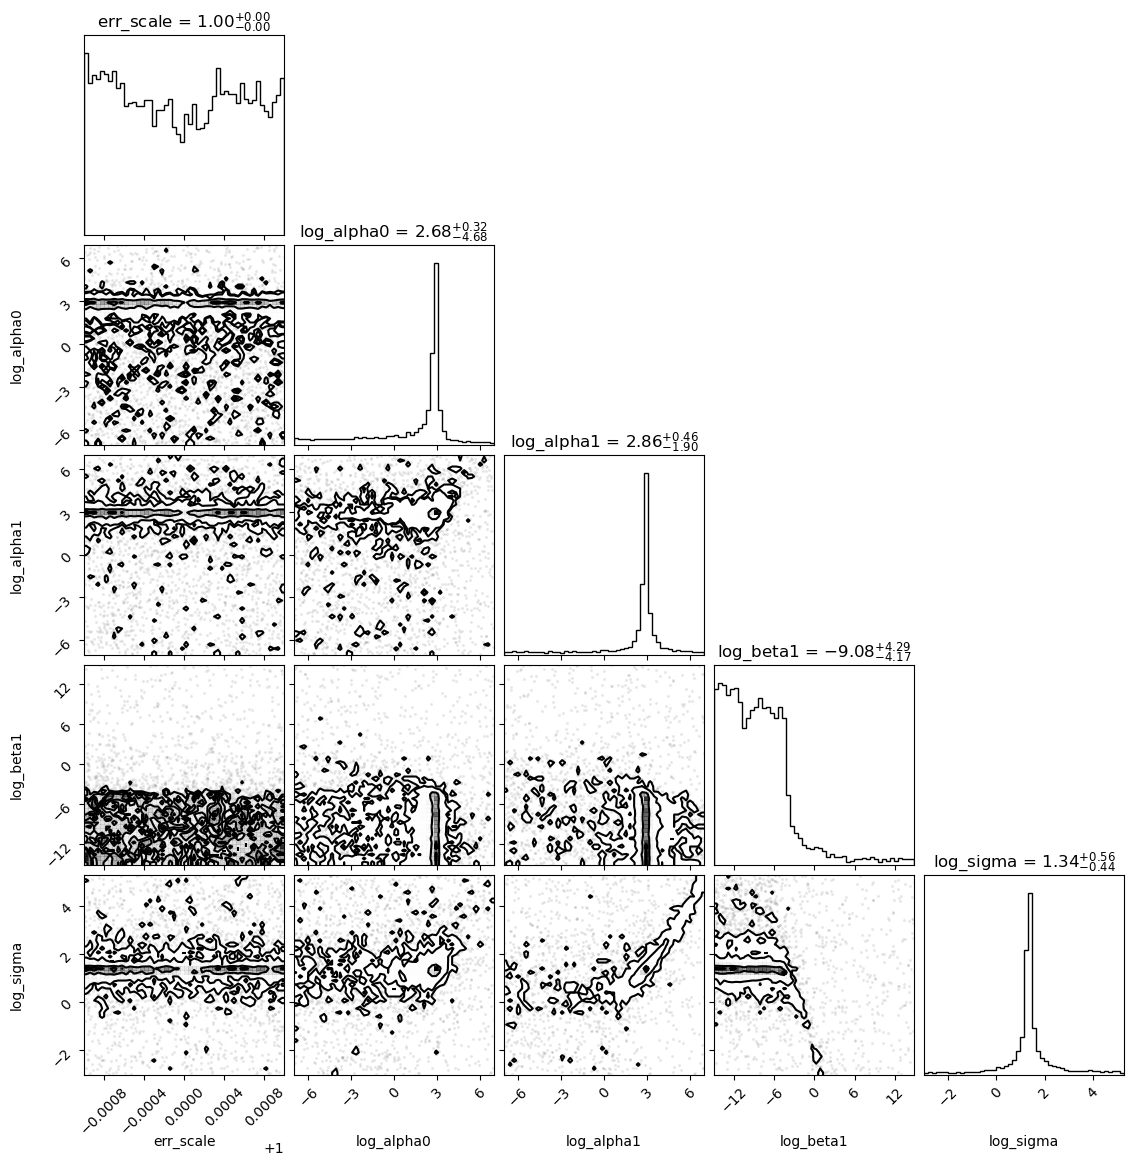

In [16]:
plot_corner(CARMA21_dict)
plot_corner(CARMA21sine_dict)

WARNING[2024-04-19 14:46:19,420]: Too few points to create valid contours


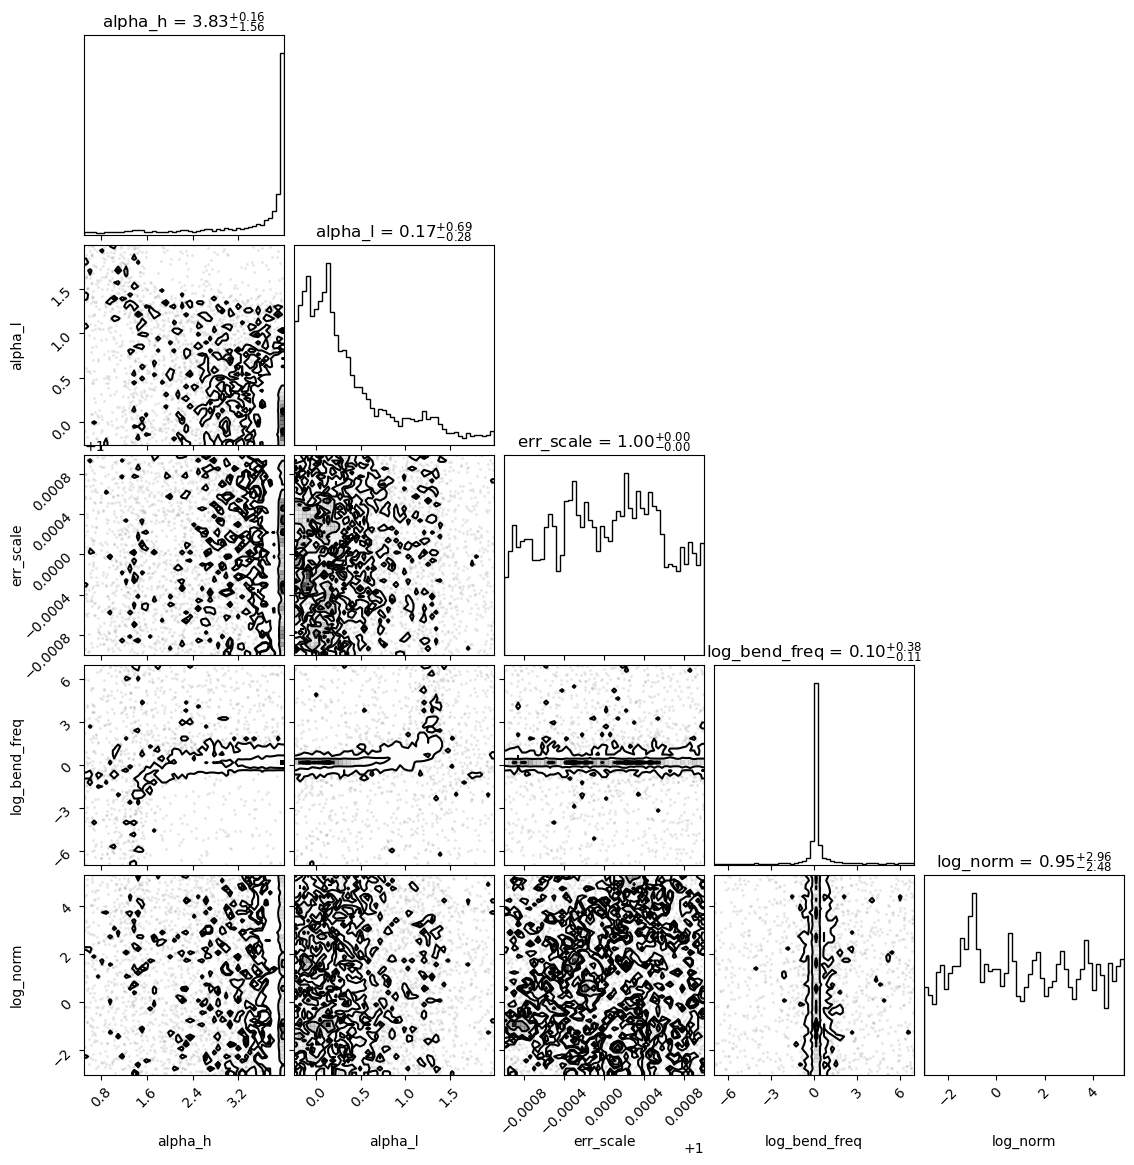

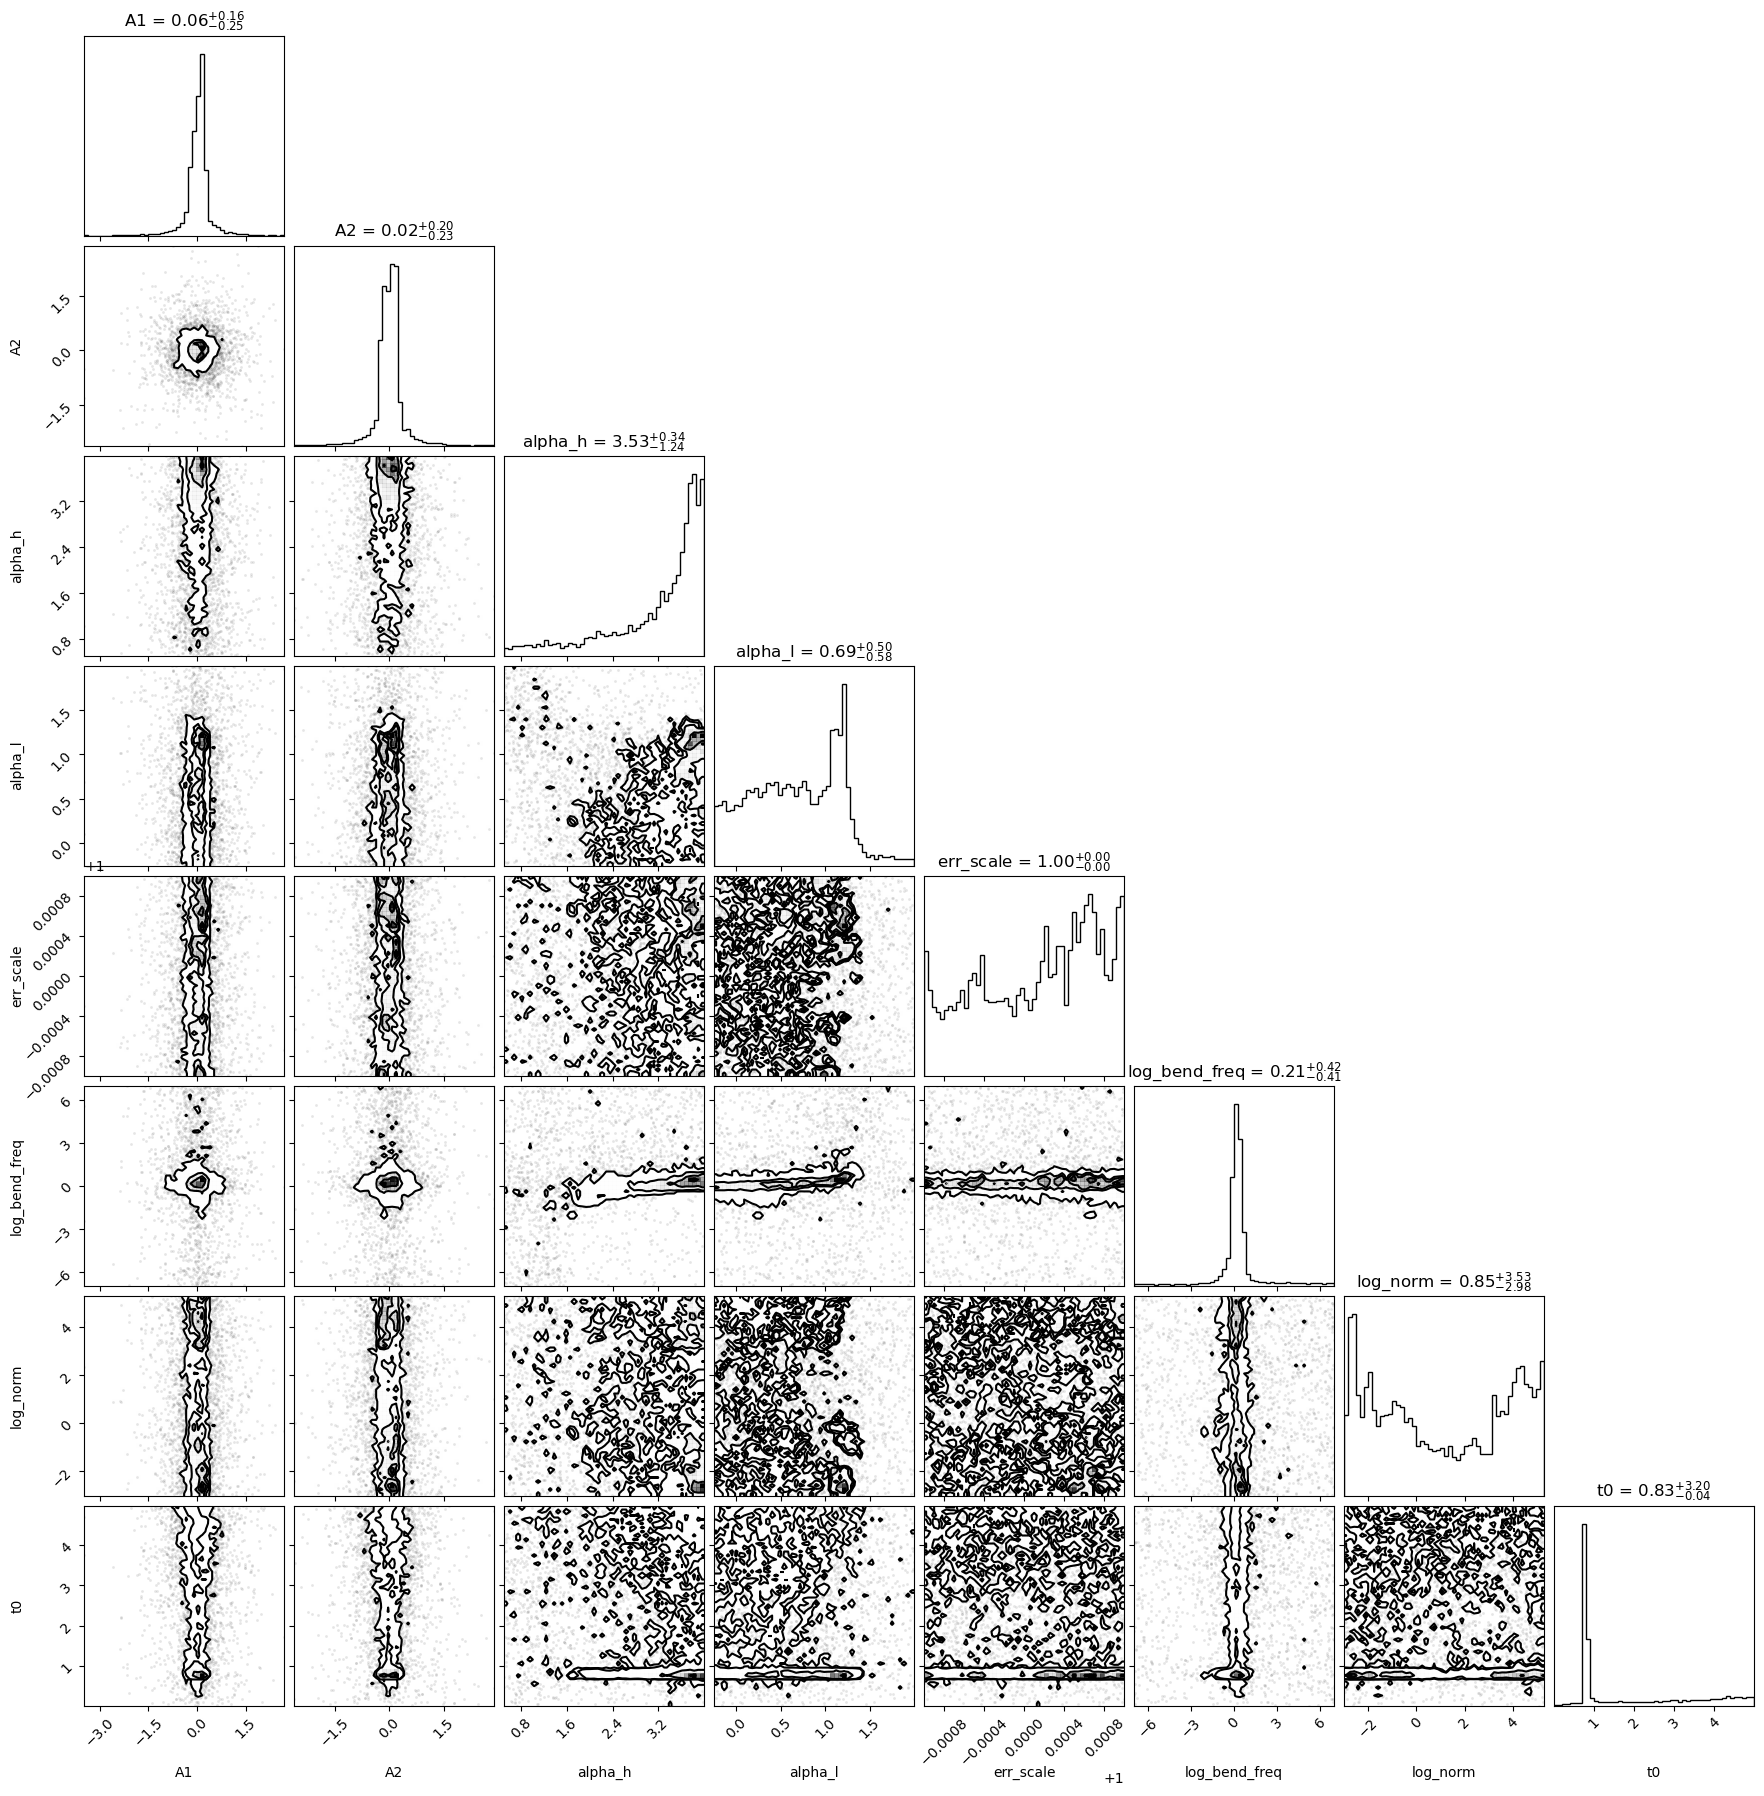

In [32]:
plot_corner(OBPL10_dict)
plot_corner(OBPLsine10_dict)

WARNING[2024-04-17 16:31:05,913]: Too few points to create valid contours
WARNING[2024-04-17 16:31:06,345]: Too few points to create valid contours
WARNING[2024-04-17 16:31:06,369]: Too few points to create valid contours


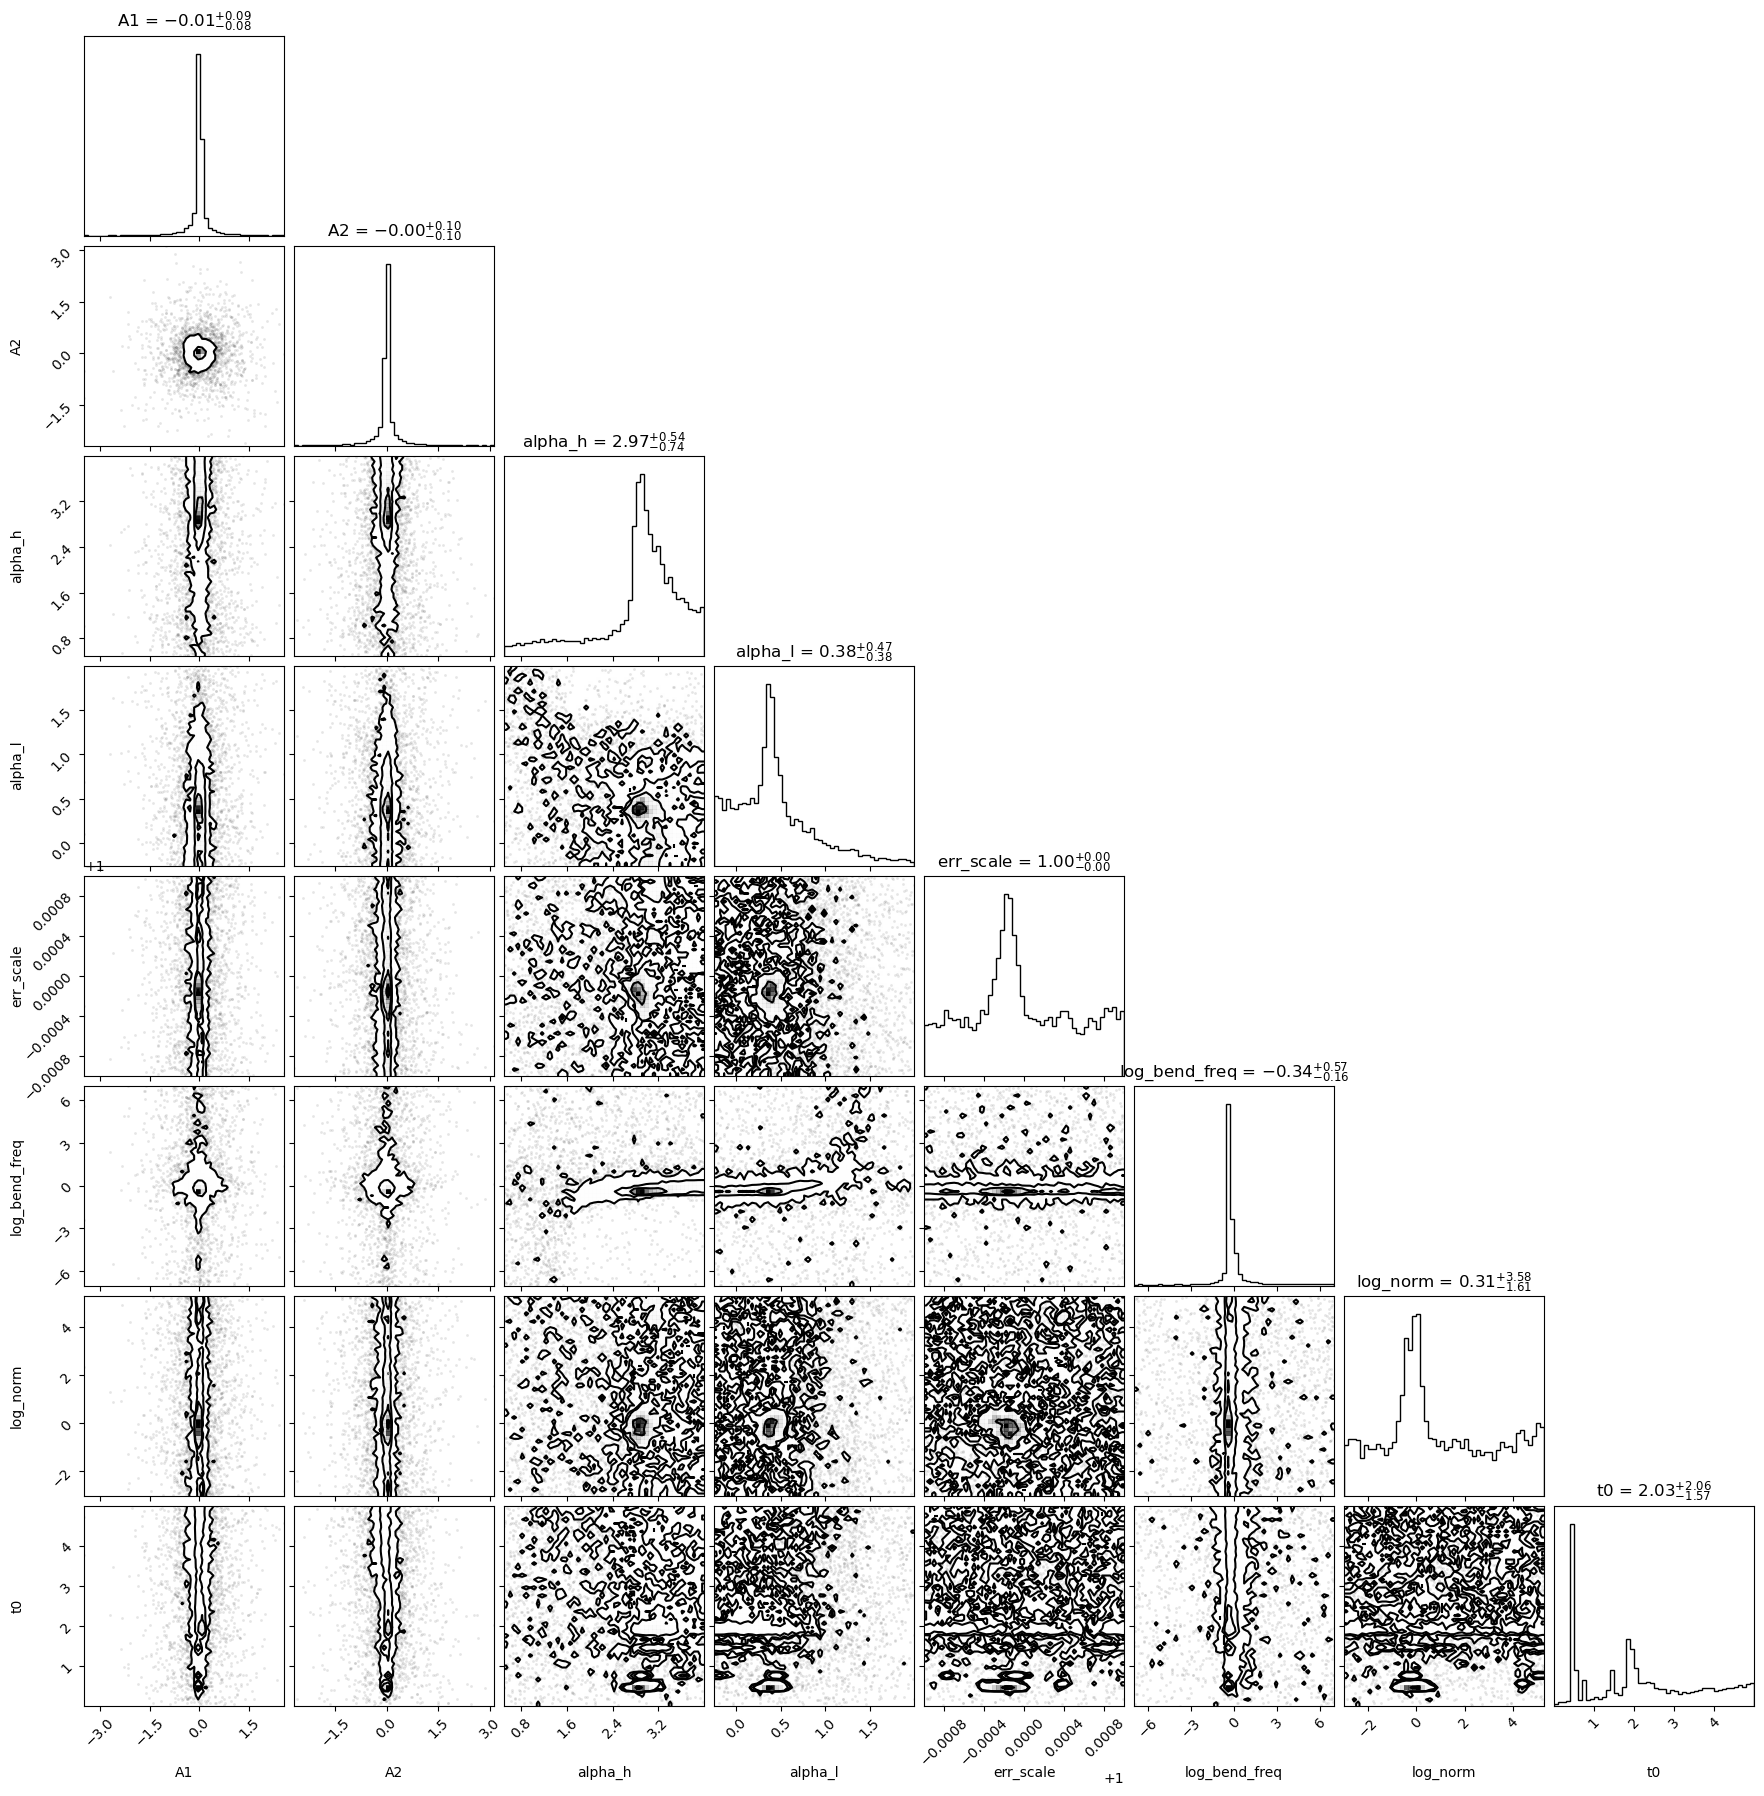

In [19]:
plot_corner(OBPLsine10_dict)

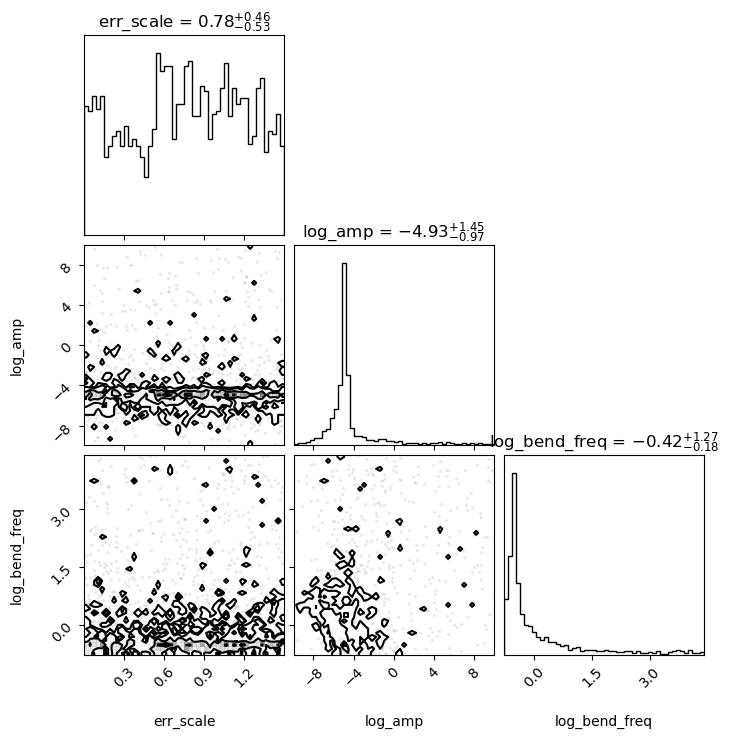

In [13]:
plot_corner(DRW_dict)

In [22]:
def plot_vertical_line(ax, x_position, text, c='red', ypos = 0.2, boxalpha = 1, textalpha=0.3):
        ax.axvline(x=x_position, color=c, linestyle='--', alpha=0.3, zorder=1)
        
        trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
        
        ax.text(x_position, ypos, text, color=c, bbox = dict(facecolor = 'white',edgecolor = 'none', alpha =boxalpha),
                ha='center', va='center', transform=trans, rotation = 90, alpha=textalpha, zorder=2, weight='bold')

def lomb_scargle_periodogram_ax(ax , time, flux,normalise = True):
    plot_freq, plot_spec = LombScargle(time, flux,normalization="psd").autopower()
    if normalise:
        ax.plot(plot_freq,  savgol_filter(plot_spec, 1, 0)/np.max(plot_spec), 'k.-', lw=0.5)
    else :
        ax.plot(plot_freq,  savgol_filter(plot_spec, 1, 0), 'k.-', lw=0.5)
    # ax[1].plot(plot_freq, moving_average_interpolated(plot_spec,50), 'r-' )
    ax.set_yscale('log')
    ax.set_xscale('log')
    # ax[1].set_title('Power Spectrum')
    ax.set_xlabel(r'$\nu$',fontsize=16)
    ax.set_ylabel(r'$P_{\nu}$',fontsize=16)
    ax.grid(True)
    ax.tick_params(labelsize = 13)
    for val in [0.5, 1, 3, 9]:
        plot_vertical_line(ax, 1/(val), str(val)+' years')
    for val in [10, 100]:
        plot_vertical_line(ax, 1/(val/365), str(val)+' days')
    
    ax_top = ax.twiny()  
    ax_top.set_xlabel('timescale [years]', fontsize = 12) 
    ax_top.plot(1/plot_freq, plot_spec,'r-', lw=3, alpha=0.0)
    ax_top.set_xscale('log')
    ax_top.set_yscale('log')
    ax_top.tick_params(axis='x')
    ax_top.invert_xaxis()
    
    return plot_freq, plot_spec

def sample_posterior(param_samples, num_samples):
    
    num_params = param_samples.shape[1]

    sampled_indices = np.random.choice(param_samples.shape[0], size=num_samples, replace=False)

    sampled_params = param_samples[sampled_indices]

    return sampled_params

def build_gp_OBPL(theta, X, diag, y, mean_val = 0, n_component = 4):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_norm = theta["log_norm"]
    alpha_l = theta["alpha_l"]
    alpha_h = theta["alpha_h"]
    log_bend_freq = theta["log_bend_freq"]
    err_scale = theta['err_scale']

    psd = OneBendPowerLaw([jnp.exp(log_norm), alpha_l, jnp.power(10, log_bend_freq), alpha_h], free_parameters=[True]*4)
    model_ACV = PSDToACV(psd, S_low=100,
                S_high=20,
                T=X[-1] - X[0],
                dt=np.min(np.diff(X)),
                method='SHO',
                n_components=n_component,
                estimate_variance=True,
                init_variance=jnp.var(y, ddof=1),
                use_celerite=False,
                use_legacy_celerite=False )
    
    kernel = model_ACV.ACVF
    
    return GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=0)

def LC_PSD_OBPL_plotter(model_dict, time, flux, fluxerr, plot_samples = False):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {}
        for (key, val) in model_dict.items():
            params[key] = np.median(val)
        params_sigma = {}
        for (key, val) in model_dict.items():
            params_sigma[key] = np.std(val)
        
        print(params)
        
        gp = build_gp_OBPL(params, time, fluxerr, flux, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        ax[0].grid()
        
        time = time # time conversion to days

        plot_freq, plot_spec = lomb_scargle_periodogram_ax(ax[1], time, flux)

        PSD = OneBendPowerLaw([jnp.exp(params['log_norm']), params['alpha_l'], jnp.power(10, params['log_bend_freq']), params['alpha_h']], free_parameters=[True]*4).calculate(plot_freq)
        #PSD_upper = DRW_PSD_function({i: params.get(i, 0) + params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq )
        #PSD_lower = DRW_PSD_function({i: params.get(i, 0) - params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq )
        
        
        ax[1].axvline(jnp.power(10, params['log_bend_freq']), color = 'k', lw = 3)
        
        for i_plot in range(100):
            par_list = sample_posterior(np.array(list(model_dict.values())[2:]).T, num_samples=1).flatten()
            par_list_dict = {}
            for (key, val) in zip(list(model_dict.keys())[2:],par_list):
                par_list_dict[key] = val
            OBPL_PSD = OneBendPowerLaw([jnp.exp(par_list_dict['log_norm']), par_list_dict['alpha_l'],
                                        jnp.power(10, par_list_dict['log_bend_freq']), par_list_dict['alpha_h']], free_parameters=[True]*4)
            ax[1].plot(plot_freq, OBPL_PSD.calculate(plot_freq), '-', color='orange', alpha=0.3)
            
        ax[1].plot(plot_freq, PSD, 'r-', lw=3)
        plt.tight_layout()
        plt.show()
        
        
def DRW_PSD_function(params, freq):
    
    
    scale = 1/jnp.power(10,params['log_bend_freq'])
    PSD = np.sqrt(2/np.pi) *jnp.exp(params['log_amp']) * scale/(1 + (freq*scale)**2)
    
    return PSD

def build_gp_DRW(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_amp = theta["log_amp"]
    log_bend_freq = theta["log_bend_freq"]
    err_scale = theta['err_scale']

    kernel = jnp.exp(log_amp) * kernels.Exp(scale = 1/jnp.power(10,log_bend_freq))
    

    return GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean= mean_val)

def search_elements_with_pattern(arr, pattern):
    matched_elements = []
    for element in arr:
        if re.search(pattern, element):
            matched_elements.append(element)
    return matched_elements


def build_gp_CARMA(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_alpha0 = theta["log_alpha0"]
    log_alpha1 = theta["log_alpha1"]
    log_beta1 = theta["log_beta1"]
    log_sigma = theta["log_sigma"]
    err_scale = theta['err_scale']

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1)])
    
    gp = GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=mean_val)
    
    return gp

def build_gp_CARMA31(theta, X, diag, mean_val = 0):

    # We want most of our parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    log_alpha0 = theta["log_alpha0"]
    log_alpha1 = theta["log_alpha1"]
    log_alpha2 = theta["log_alpha2"]
    log_beta1 = theta["log_beta1"]
    log_sigma = theta["log_sigma"]
    err_scale = theta['err_scale']

    kernel = kernels.quasisep.CARMA.init(alpha=[jnp.exp(log_alpha0), jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                                    beta=[jnp.exp(log_sigma)*1, jnp.exp(log_sigma)*jnp.exp(log_beta1)])
    
    gp = GaussianProcess(kernel, X, diag=(err_scale*diag)**2, mean=mean_val)
    
    return gp


def CARMA_PSD_pq(params, freq):
    key_list = np.array(list(params.keys()))

    alpha_keys = search_elements_with_pattern(key_list, 'alpha')
    beta_keys = search_elements_with_pattern(key_list, 'beta')
    sigma = jnp.exp(params[search_elements_with_pattern(key_list, 'sigma')[0]])

    alpha_vals = []
    for key in alpha_keys:
        alpha_vals.append(params[key])
    alpha_vals =list(jnp.exp(np.array(alpha_vals)))
    
    alpha_vals.append(1)
    
    beta_vals = [1]
    for key in beta_keys:
        beta_vals.append(params[key])
        
    beta_vals = list(jnp.exp(np.array(beta_vals)))
    p = len(alpha_keys)
    q = len(beta_keys)
    #print(p,q)
    num = 0 
    denom = 0

    for i in range(q+1):
        num = num + (beta_vals[i]*(2*np.pi*1j* freq)**i )
    for u in range(p+1):
        denom = denom + (alpha_vals[u]*(2*np.pi*1j* freq)**u )

    PSD = sigma**2 *  (np.abs(num)**2)/(np.abs(denom)**2)
    
    return PSD

def LC_PSD_plotter(model_dict, time, flux, fluxerr, plot_samples = False , plot_what = 'all'):
    if (plot_what=='DRW'):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {}
        for (key, val) in model_dict.items():
            params[key] = np.median(val)
        params_sigma = {}
        for (key, val) in model_dict.items():
            params_sigma[key] = np.std(val)
        
        print(params)
        
        gp = build_gp_DRW(params, time, fluxerr, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        ax[0].grid()
        
        time = time # time conversion to days

        plot_freq, plot_spec = lomb_scargle_periodogram_ax(ax[1], time, flux)

        PSD = DRW_PSD_function( params, plot_freq)
        #PSD_upper = DRW_PSD_function({i: params.get(i, 0) + params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq )
        #PSD_lower = DRW_PSD_function({i: params.get(i, 0) - params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq )
        
        
        ax[1].axvline(jnp.power(10,params['log_bend_freq']), color = 'k', lw = 3)
        
        for i_plot in range(50):
            par_list = sample_posterior(np.array(list(model_dict.values())[2:]).T, num_samples=1).flatten()
            par_list_dict = {}
            for (key, val) in zip(list(model_dict.keys())[2:],par_list):
                par_list_dict[key] = val

            ax[1].plot(plot_freq, DRW_PSD_function(par_list_dict, plot_freq), '-', color='orange', alpha=0.5)
            
        ax[1].plot(plot_freq, PSD, 'r-', lw=3)
        plt.tight_layout()
        plt.show()
        
    if (plot_what=='DRWsine'):
        t_new = np.linspace(min(time)-1, max(time)+1, 1000)
        params = {}
        for (key, val) in model_dict.items():
            params[key] = np.mean(val)
        params_sigma = {}
        for (key, val) in model_dict.items():
            params_sigma[key] = np.std(val)

        print(params)
        
        gp = build_gp_DRW(params, time, fluxerr, mean_val=partial(sine_curve_model, params))
        cond_gp = gp.condition(flux, t_new).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        ax[0].errorbar(time,flux,yerr=fluxerr,fmt='.', color='k',alpha = 0.3 )
        
        ax[0].plot(t_new, jax.vmap(partial(sine_curve_model, params))(t_new)  , color="r", lw=3, alpha=1, label = 'Sine in DRW+Sine')
        if plot_samples:
            ax[0].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1043)), 'r-', alpha=0.3)
            ax[0].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1042)), 'b-', alpha=0.3)
            ax[0].plot(t_new, cond_gp.sample(jax.random.PRNGKey(1044)), 'g-', alpha=0.3)
        ax[0].fill_between(t_new, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        ax[0].legend(fontsize=14)
        
        time = time # time conversion to days

        plot_freq, plot_spec = lomb_scargle_periodogram_ax(ax[1], time, flux)
        PSD = DRW_PSD_function( params, plot_freq)
        #PSD_upper = DRW_PSD_function({i: params.get(i, 0) + params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq )
        #PSD_lower = DRW_PSD_function({i: params.get(i, 0) - params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq )
        
        
        ax[1].axvline(1/params['scales'], color = 'k', lw = 3)
        for i_plot in range(50):
            par_list = sample_posterior(np.array(list(model_dict.values())[2:]).T, num_samples=1).flatten()
            par_list_dict = {}
            for (key, val) in zip(list(model_dict.keys())[2:],par_list):
                par_list_dict[key] = val

            ax[1].plot(plot_freq, DRW_PSD_function(par_list_dict, plot_freq), '-', color='orange', alpha=0.5)
    
        ax[1].plot(plot_freq, PSD, 'r-', lw=3)
        plt.tight_layout()
        plt.show()
    if (plot_what=='CARMA21'):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {}
        for (key, val) in model_dict.items():
            params[key] = np.mean(val)
        params_sigma = {}
        for (key, val) in model_dict.items():
            params_sigma[key] = np.std(val)
        
        print(params)
        
        gp = build_gp_CARMA(params, time, fluxerr, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        
        time = time # time conversion to days

        plot_freq, _ = lomb_scargle_periodogram_ax(ax[1], time, flux)

        #PSD1 =  CARMA21_PSD_function( params, plot_freq)
        PSD =  CARMA_PSD_pq( params, plot_freq)
        #PSD_upper = CARMA_PSD_pq( {i: params.get(i, 0) + params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq)
        #PSD_lower = CARMA_PSD_pq( {i: params.get(i, 0) - params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq)
        #ax[1].plot(plot_freq, PSD1, 'r-', lw=3)
        for i_plot in range(50):
            par_list = sample_posterior(np.array(list(model_dict.values())[2:]).T, num_samples=1).flatten()
            par_list_dict = {}
            for (key, val) in zip(list(model_dict.keys())[2:],par_list):
                par_list_dict[key] = val

            ax[1].plot(plot_freq, CARMA_PSD_pq(par_list_dict, plot_freq), '-', color = 'orange', alpha=0.3)
            
        ax[1].plot(plot_freq, PSD, 'r-', lw=3)
        plt.tight_layout()
        plt.show()
    
    if (plot_what=='CARMA31'):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {}
        for (key, val) in model_dict.items():
            params[key] = np.mean(val)
        params_sigma = {}
        for (key, val) in model_dict.items():
            params_sigma[key] = np.std(val)
        
        print(params)
        
        gp = build_gp_CARMA31(params, time, fluxerr, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        
        time = time # time conversion to days

        plot_freq, _ = lomb_scargle_periodogram_ax(ax[1], time, flux)

        PSD =  CARMA_PSD_pq( params, plot_freq)
        #PSD_upper = CARMA_PSD_pq( {i: params.get(i, 0) + params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq)
        #PSD_lower = CARMA_PSD_pq( {i: params.get(i, 0) - params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq)
        #ax[1].plot(plot_freq, PSD1, 'r-', lw=3)
        for i_plot in range(50):
            par_list = sample_posterior(np.array(list(model_dict.values())[2:]).T, num_samples=1).flatten()
            par_list_dict = {}
            for (key, val) in zip(list(model_dict.keys())[2:],par_list):
                par_list_dict[key] = val

            ax[1].plot(plot_freq, CARMA_PSD_pq(par_list_dict, plot_freq), '-', color = 'orange', alpha=0.3)
            
        ax[1].plot(plot_freq, PSD, 'r-', lw=3)
        plt.tight_layout()
        plt.show()
        
    if (plot_what=='CARMA10'):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {'log_alpha0'  :np.median(model_dict['log_alpha0']),
                'log_sigma':np.median(model_dict['log_sigma']),
                'err_scale':np.median(model_dict['err_scale'])}
        
        print(params)
        
        gp = build_gp_CARMA10(params, time, fluxerr, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        
        time = time # time conversion to days

        plot_freq, _ = lomb_scargle_periodogram_ax(ax[1], time, flux)


        PSD = CARMA10_PSD_function( params, plot_freq)
        ax[1].plot(plot_freq, PSD/np.max(PSD[0:1]), 'r-')
    
        plt.tight_layout()
        plt.show()
        
    if (plot_what=='CARMA64'):
        x = np.linspace(min(time)-2, max(time)+2, 1000)
        params = {}
        for (key, val) in model_dict.items():
            params[key] = np.median(val)
        #params_sigma = {}
        #for (key, val) in model_dict.items():
        #    params_sigma[key] = np.std(val)
        
        print(params)
        
        gp = build_gp_CARMA64(params, time, fluxerr, mean_val=0)
        cond_gp = gp.condition(flux, x).gp
        mu, var = cond_gp.loc, cond_gp.variance

        fig, ax = plt.subplots(1,2, figsize=[14,6])
        if plot_samples:
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1041)), "r-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1042)), "b-", lw=1, alpha=0.3)
            ax[0].plot(x, cond_gp.sample(jax.random.PRNGKey(1043)), "r-", lw=1, alpha=0.3)
        ax[0].errorbar(time, flux,yerr=fluxerr,fmt='.', color='k' , alpha=0.2)
        ax[0].fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="orange", alpha=0.5)
        
        ax[0].tick_params(labelsize=13)
        ax[0].set_xlabel('Time [years]', fontsize=15)
        ax[0].set_ylabel('Normalised Flux', fontsize=15)
        
        time = time # time conversion to days

        plot_freq, _ = lomb_scargle_periodogram_ax(ax[1], time, flux)


        PSD = CARMA_PSD_pq( params, plot_freq)
        #PSD_upper = CARMA_PSD_pq( {i: params.get(i, 0) + params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq)
        #PSD_lower = CARMA_PSD_pq( {i: params.get(i, 0) - params_sigma.get(i, 0) for i in set(params).union(params_sigma)}, plot_freq)
        
        
        for i_plot in range(50):
            par_list = sample_posterior(np.array(list(model_dict.values())[2:]).T, num_samples=1).flatten()
            par_list_dict = {}
            for (key, val) in zip(list(model_dict.keys())[2:],par_list):
                par_list_dict[key] = val

            ax[1].plot(plot_freq, CARMA_PSD_pq(par_list_dict, plot_freq), '-', color='orange', alpha=0.5)
        ax[1].plot(plot_freq, PSD, 'r-', lw=3)
        #ax[1].fill_between(plot_freq, PSD_upper, PSD_lower, color='orange', alpha=0.5  )
    

        plt.tight_layout()
        plt.show()    
    

In [23]:
LC_PSD_OBPL_plotter(OBPLsine10_dict, lcTIME, lcFLUX, lcFLUXerr)
#LC_PSD_OBPL_plotter(OBPL_4_dict, lcTIME, lcFLUX, lcFLUXerr)

{'log_Z_mean': 414.23353942303277, 'log_Z_uncert': 0.168996865936863, 'A1': 0.15688020280433906, 'alpha_h': 2.689801727941738, 'alpha_l': 0.206477000122254, 'log_bend_freq': -0.2923800852607876, 'log_norm': 2.818261970591994, 'phi': 0.7929136375193537, 't0': 1.719539593455028}


KeyError: 'err_scale'

In [24]:
LC_PSD_plotter(DRW_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='DRW')

{'log_Z_mean': 399.7142114660951, 'log_Z_uncert': 0.11699067979121508, 'log_amp': -3.7752976157963465, 'log_bend_freq': -0.06367282811674446}


KeyError: 'err_scale'

{'log_Z_mean': 909.4163965797894, 'log_Z_uncert': 0.1917593901681811, 'err_scale': 0.7683103532350694, 'log_alpha0': 2.3140769796947263, 'log_alpha1': 2.8999562253123536, 'log_alpha2': 3.9626306862907428, 'log_beta1': 0.4534821962445327, 'log_sigma': 1.4296017279914246}


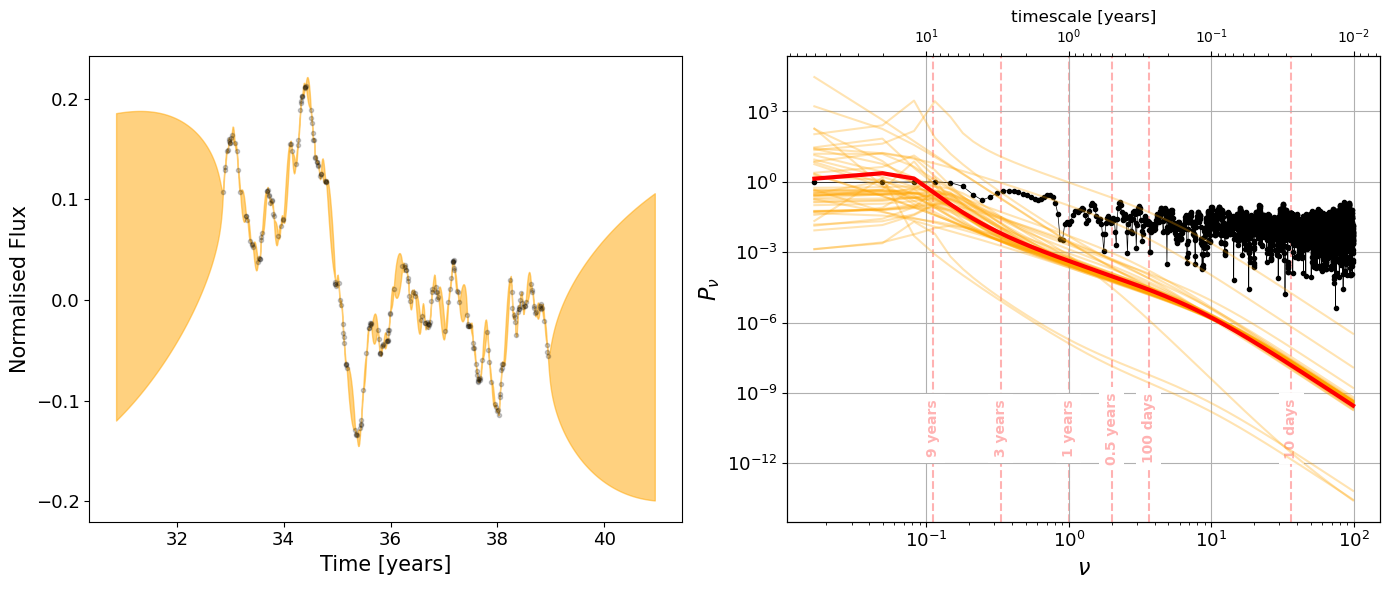

In [49]:
LC_PSD_plotter(CARMA31_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='CARMA31')

{'log_Z_mean': 907.6378144974296, 'log_Z_uncert': 0.20183008566180063, 'err_scale': 0.6518057220075788, 'log_alpha0': 2.653984788908054, 'log_alpha1': 3.239356910078061, 'log_beta1': -5.4071900687389975, 'log_sigma': 1.512634228438816}


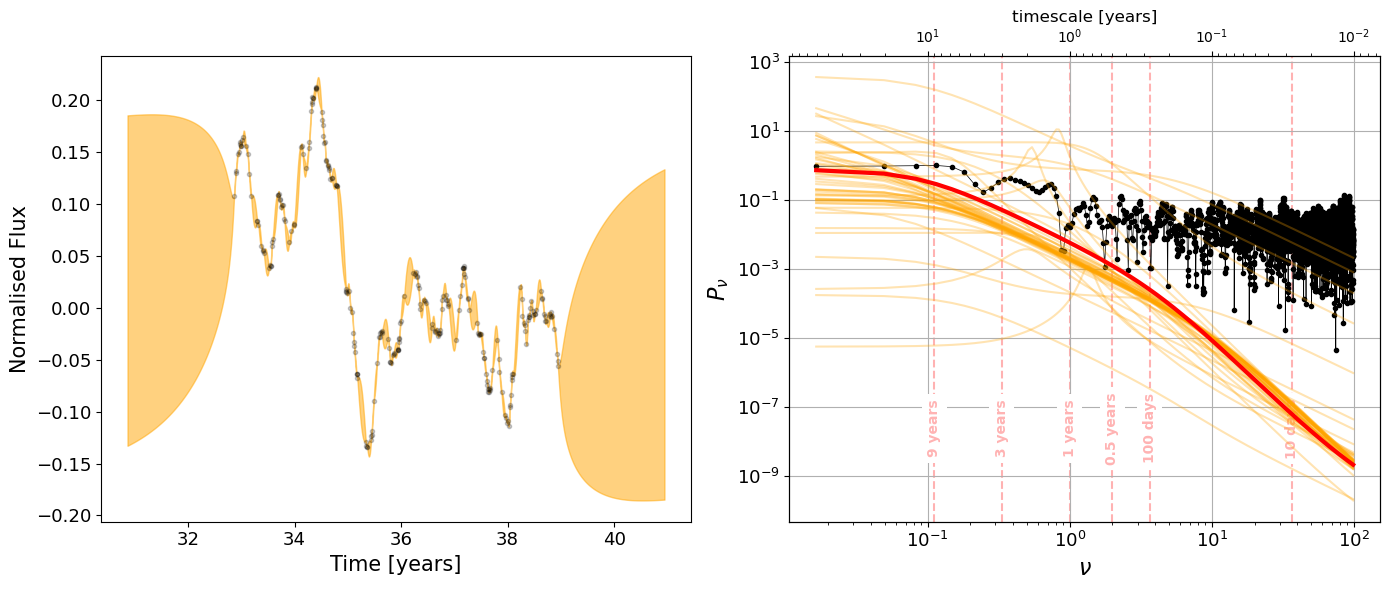

In [50]:
LC_PSD_plotter(CARMA21_dict, lcTIME, lcFLUX, lcFLUXerr, plot_what='CARMA21')